In [ ]:
%matplotlib inline


Neural Networks
===============

神经网络可以用 ``torch.nn`` 包构建.

之前说过 ``autograd``, ``nn`` 依赖于
``autograd`` 来定义模型并微分它们.<br>
一个 ``nn.Module`` 含有层(layers), 以及方法： ``forward(input)``\ 来产生 ``output``.<br>

例如，看看这个对数字图像进行分类的网络:
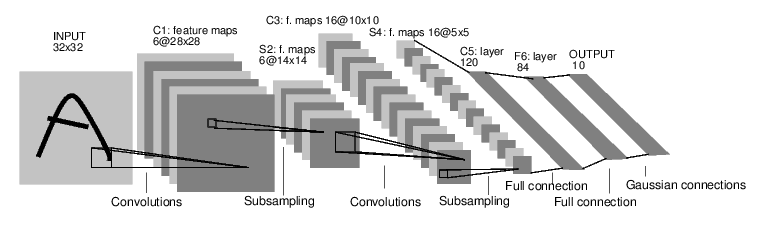


它是一个简单的前馈网络。它接受输入，一个接一个地通过几个层为其提供数据，最后给出输出。

神经网络的典型训练过程如下:

- 定义具有一些可学习参数的神经网络(或权重)
- 遍历输入数据集
- 通过神经网络处理模型输入
- 计算损失LOSS(输出距离期望有多远)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

Define the network
------------------

开打！！



--[为什么这么搭前向网络](https://blog.csdn.net/qq_37942706/article/details/83302688)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # 1输入图像通道，6输出通道，5x5平方卷积
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)        #对应图C1 6 28 28
        self.conv2 = nn.Conv2d(6, 16, 5)       #对应图C3 16 10 10
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  #对应图C5 全连接层
        self.fc2 = nn.Linear(120, 84)          #对应图F6
        self.fc3 = nn.Linear(84, 10)           #对应图c7

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)),(2, 2))#降采样，卷积第一层的输出=pool层(经过relu函数激活(第一层F.(的输入)),(2,2)的pooling窗口--S2)
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)   #降采样，卷积第二层的输出=pool层(经过relu函数激活(第二层F.(的输入)),(2,2)的pooling窗口--S4)
        x = x.view(-1, self.num_flat_features(x))    #线性层和卷积层之间的承接  将矩阵重塑成向量传入
        x = F.relu(self.fc1(x)) #      第一层的输出=经过relu函数激活(第一层F.(的输入))
        x = F.relu(self.fc2(x)) #      第二层的输出=经过relu函数激活(第二层F.(的输入))
        x = self.fc3(x)         #      第三层的输出=(第三层F.(的输入))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


你只需要定义 ``forward`` 函数, 反向传播 ``backward``<br>
函数 (用来计算梯度) 被自动定义只要你使用``autograd``.<br>
你可以用任意张量运算在 ``forward`` function.<br>

模型的可学习参数由 ``net.parameters()``返回<br>



In [3]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # 卷积层1的参数size

10
torch.Size([6, 1, 5, 5])


让我们试一个随机的 **32x32** input.<br>
Note: 这个网络(LeNet)的预期输入大小为32x32. 用这个网<br>
MNIST数据集，请将数据集中的图像大小调整为32x32.<br>



In [6]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0026,  0.0971,  0.0745,  0.0070,  0.0055,  0.0213,  0.0418,  0.0082,
         -0.0330, -0.0023]], grad_fn=<AddmmBackward>)


清零： 梯度缓存 of 所有参数 and 反向传播的随机梯度:



In [7]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` 只支持小批量样本. The entire ``torch.nn``
    package 只支持一小批样品，而不是一个样品.

    例如, ``nn.Conv2d`` 会接受 a 4维度
    ``nSamples x nChannels x Height x Width``.形式的张量

    如果只有一个样本, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.

在继续之前，让我们先回顾一下到目前为止所见过的所有类.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**至此，我们已经讨论过了:**
  -  定义神经网络
  -  前向反向传播

**还剩下:**
  -  计算loss
  -  更新网络的权重

Loss Function
-------------
损失函数接受(输出、目标)输入对，并计算一个值，该值估计输出与目标的差距。

有几个不同的

-[loss functions](https://pytorch.org/docs/nn.html#loss-functions) under the
nn package .
一个简单的loss: ``nn.MSELoss`` 计算输入和目标之间的均方误差.

For example:



In [8]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.4534, grad_fn=<MseLossBackward>)


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:
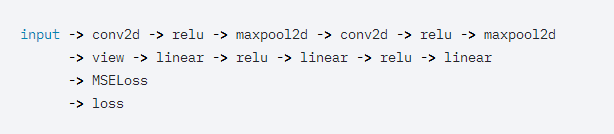

所以，当我们调用 ``loss.backward()``, 整个图都会求对于loss的微分,图中所有 ``requires_grad=True``要求被记录梯度的张量
将会把她们所得的梯度累加到 ``.grad`` Tensor 这个属性中.

For illustration, let us follow a few steps backward:



In [9]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop
--------
要反向传播这个误差，我们所要做的就是 ``loss.backward()``.<br>
不过，您需要清除现有的梯度，否则梯度将累积为现有梯度。<br>


再次调用 ``loss.backward()``, 看一看卷积层 conv1传播前后的梯度.



In [10]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0101, -0.0056,  0.0034, -0.0023, -0.0032, -0.0034])


现在，我们已经学习了如何使用损失函数。

**稍后阅读:**

  神经网络包 nn 包含各种模块和损失函数<br>
  形成了深层神经网络的基石. <br>
   `here <https://pytorch.org/docs/nn>`_.--[nn.的文档](https://pytorch.org/docs/nn)

**唯一还未学习的是:**

  - 更新网络的权重

Update the weights
------------------
在实践中使用的最简单的更新规则是随机梯度
下降 the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

我们可以使用简单的python代码实现这一点:



    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

然而，当你使用神经网络时，你想要使用各种不同的<br>

更新规则，如SGD、Nesterov-SGD、Adam、RMSProp等<br>

为了实现这一点，我们构建了一个小包 : **torch.optim**<br>

那是对所有这些方法的补充。使用它很简单:
<br>


In [11]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

观察梯度缓冲区必须手动设置为零,使用函数<br>
__optimizer.zero_grad()__. 这是因为梯度是累积的<br>
正如`Backprop`小节所说的.<br>

